# **Adversarial Attack**

## Enviroment & Download Data


In [1]:
# set up environment
!pip install pytorchcv
!pip install imgaug
# download dataset
!wget https://www.dropbox.com/s/lbpypqamqjpt2qz/data.zip

# unzip
!unzip ./data.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 24.9 MB/s eta 0:00:00
--2024-11-30 04:57:59--  https://www.dropbox.com/s/lbpypqamqjpt2qz/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/hp1asboajakihzavykt5v/data.zip?rlkey=v9x0j0udqonkwccz2jpe2tkkf [following]
--2024-11-30 04:57:59--  https://www.dropbox.com/scl/fi/hp1asboajakihzavykt5v/data.zip?rlkey=v9x0j0udqonkwccz2jpe2tkkf
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc89e6bfa17d245c491c95d4b669.dl.dropboxusercontent.com/cd/0/inline/CfUXPuaZ-MViafULWHt29caCicdm_EOAe6V0MP_EqB4KJa0O4daWYL9KijRVi4xlot6a4jbCi89rMYL7C-gYs57Oq1CvGUQuUH5OAkzxeIBKiv0Sg-vI-6oaL

In [2]:
import torch
import torch.nn as nn
from pytorchcv.model_provider import get_model as ptcv_get_model
import random
import numpy as np


In [3]:
batch_size = 8
def same_seeds(seed):
			torch.manual_seed(seed)
			if torch.cuda.is_available():
					torch.cuda.manual_seed(seed)
					torch.cuda.manual_seed_all(seed)
			np.random.seed(seed)
			random.seed(seed)
			torch.backends.cudnn.benchmark = False
			torch.backends.cudnn.deterministic = True

same_seeds(0)

In [4]:
# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447)
cifar_10_std = (0.202, 0.199, 0.201)

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).view(3, 1, 1)
std = torch.tensor(cifar_10_std).view(3, 1, 1)

epsilon = 8/255/std
root = './data' # directory for storing benign images


# Data



In [5]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


# Benign Images Evaluation

In [7]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x, y
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# Model / Loss Function


In [8]:
# This function is used to check whether you use models pretrained on cifar10 instead of other datasets
def model_checker(model_name):
  print(f'You are using {model_name}!')
  assert ('cifar10' in model_name) and ('cifar100' not in model_name), 'The model selected is not pretrained on cifar10!'

In [9]:
from pytorchcv.model_provider import get_model as ptcv_get_model
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

model_name = 'resnet110_cifar10'
model_checker(model_name)
model = ptcv_get_model(model_name, pretrained=True)
loss_fn = nn.CrossEntropyLoss()

benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

You are using resnet110_cifar10!
benign_acc = 0.95000, benign_loss = 0.22678


### finding
### We note that when testing the model on healthy images, the model’s accuracy was 95%.


# Build Attack Algorithm as Function

## FGSM Attack Function

In [10]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    grad = x_adv.grad.detach()
    x_adv = x_adv + epsilon * grad.sign()
    return x_adv


In [11]:
alpha = 0.8/255/std

def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    x_adv = x.detach().clone()
    ###### TODO: Medium baseline##########
    # write a loop with num_iter times
    for i in range(num_iter):
      # TODO: Each iteration, execute fgsm
      x_adv.requires_grad = True
      output = model(x_adv)
      loss = loss_fn(output, y)
      loss.backward()

      grad = x_adv.grad.detach()
      x_adv = x_adv + alpha * grad.sign()

      delta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
      x_adv = torch.clamp(x + delta, min=0, max=1).detach()

    return x_adv


In [12]:
def mifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20, decay=0.3):
    x_adv = x.detach().clone()
    # initialze momentum tensor
    momentum = torch.zeros_like(x).detach()

   
    for i in range(num_iter):
      # Calculate the momentum and update
      x_adv.requires_grad = True

      output = model(x_adv)
      loss = loss_fn(output, y)

      loss.backward()

      grad = x_adv.grad.detach()

      momentum = decay * momentum + grad / torch.norm(grad, p=1)

      x_adv = x_adv.detach() + alpha * momentum.sign()

      delta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
      x_adv = torch.clamp(x + delta, min=0, max=1).detach()

    return x_adv

In [13]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x, y
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)


In [14]:
# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## FGSM

In [15]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

fgsm_acc = 0.59000, fgsm_loss = 2.49348


In [16]:
######## BOSS BASELINE #######

class ensembleNet(nn.Module):
    def __init__(self, model_names):
        super().__init__()
        self.models = nn.ModuleList([ptcv_get_model(name, pretrained=True) for name in model_names])

    def forward(self, x):
        # sum up logits from multiple models
        # return ensemble_logits

        ensemble_logits = None
        for i, model in enumerate(self.models):
          logits = model(x)

          if ensemble_logits is None:
            ensemble_logits = logits
          else:
            if logits.shape != ensemble_logits.shape:
              raise ValueError(f"Model {i} output shape {logits.shape} doesn't match previous shape {ensemble_logits.shape}")

            ensemble_logits += logits

        return ensemble_logits

In [19]:
model_names = [
   'resnet1202_cifar10','sepreresnet542bn_cifar10','densenet40_k36_bc_cifar10'
]

for model_name in model_names:
  model_checker(model_name)

ensemble_model = ensembleNet(model_names)
ensemble_model.eval()

You are using resnet1202_cifar10!
You are using sepreresnet542bn_cifar10!
You are using densenet40_k36_bc_cifar10!


ensembleNet(
  (models): ModuleList(
    (0): CIFARResNet(
      (features): Sequential(
        (init_block): ConvBlock(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (stage1): Sequential(
          (unit1): ResUnit(
            (body): ResBlock(
              (conv1): ConvBlock(
                (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activ): ReLU(inplace=True)
              )
              (conv2): ConvBlock(
                (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )

In [20]:
adv_examples, mifgsm_acc, mifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, mifgsm, loss_fn)
print(f'mifgsm_acc = {fgsm_acc:.5f}, mifgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'mifgsm', adv_examples, adv_names)

mifgsm_acc = 0.59000, mifgsm_loss = 2.49348


In [21]:
%cd fgsm
!tar zcvf ../fgsm.tgz *
%cd ..

/content/fgsm
airplane/
airplane/airplane3.png
airplane/airplane16.png
airplane/airplane6.png
airplane/airplane4.png
airplane/airplane2.png
airplane/airplane19.png
airplane/airplane14.png
airplane/airplane12.png
airplane/airplane15.png
airplane/airplane8.png
airplane/airplane9.png
airplane/airplane11.png
airplane/airplane20.png
airplane/airplane17.png
airplane/airplane13.png
airplane/airplane7.png
airplane/airplane1.png
airplane/airplane18.png
airplane/airplane5.png
airplane/airplane10.png
automobile/
automobile/automobile19.png
automobile/automobile11.png
automobile/automobile5.png
automobile/automobile14.png
automobile/automobile8.png
automobile/automobile3.png
automobile/automobile15.png
automobile/automobile20.png
automobile/automobile2.png
automobile/automobile7.png
automobile/automobile6.png
automobile/automobile1.png
automobile/automobile9.png
automobile/automobile17.png
automobile/automobile13.png
automobile/automobile12.png
automobile/automobile4.png
automobile/automobile16.pn

In [22]:
%cd mifgsm
!tar zcvf ../mifgsm.tgz *
%cd ..

/content/mifgsm
airplane/
airplane/airplane3.png
airplane/airplane16.png
airplane/airplane6.png
airplane/airplane4.png
airplane/airplane2.png
airplane/airplane19.png
airplane/airplane14.png
airplane/airplane12.png
airplane/airplane15.png
airplane/airplane8.png
airplane/airplane9.png
airplane/airplane11.png
airplane/airplane20.png
airplane/airplane17.png
airplane/airplane13.png
airplane/airplane7.png
airplane/airplane1.png
airplane/airplane18.png
airplane/airplane5.png
airplane/airplane10.png
automobile/
automobile/automobile19.png
automobile/automobile11.png
automobile/automobile5.png
automobile/automobile14.png
automobile/automobile8.png
automobile/automobile3.png
automobile/automobile15.png
automobile/automobile20.png
automobile/automobile2.png
automobile/automobile7.png
automobile/automobile6.png
automobile/automobile1.png
automobile/automobile9.png
automobile/automobile17.png
automobile/automobile13.png
automobile/automobile12.png
automobile/automobile4.png
automobile/automobile16.

# Example of Ensemble Attack

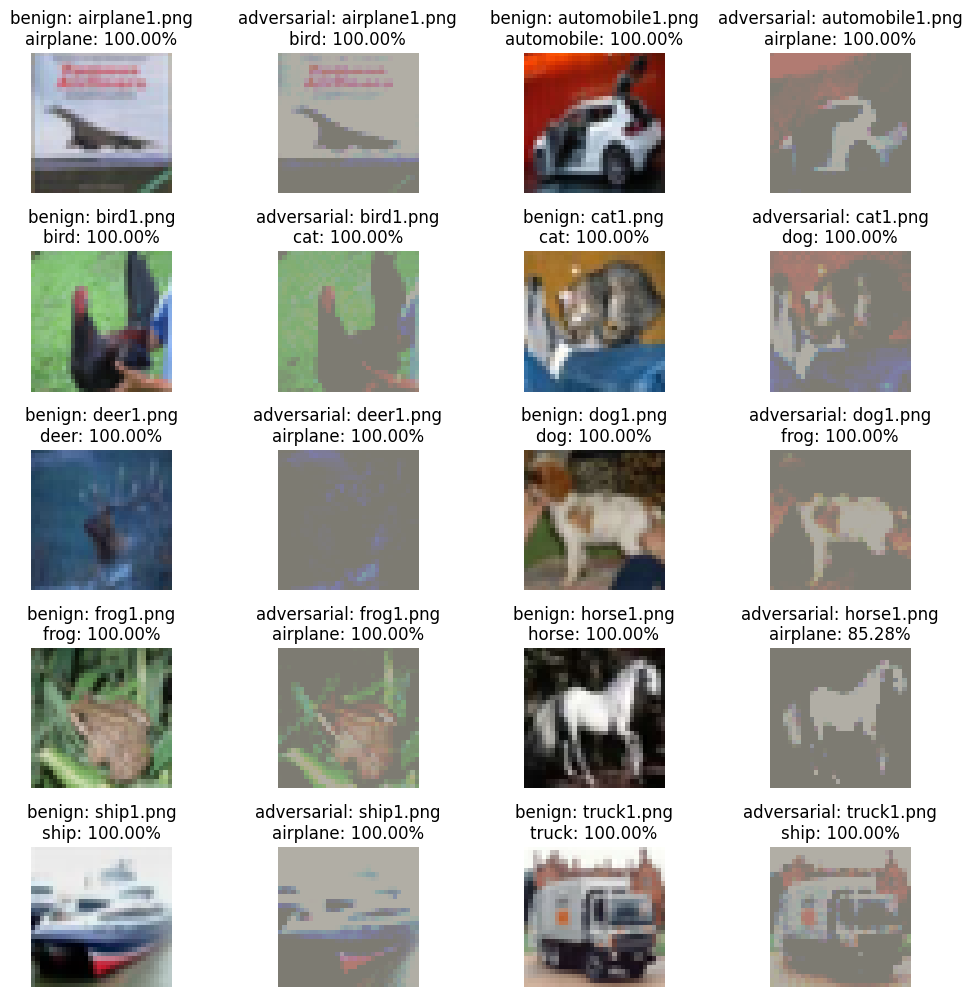

In [25]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = ensemble_model(transform(im).unsqueeze(0))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./mifgsm/{path}')
    logit = ensemble_model(transform(im).unsqueeze(0))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

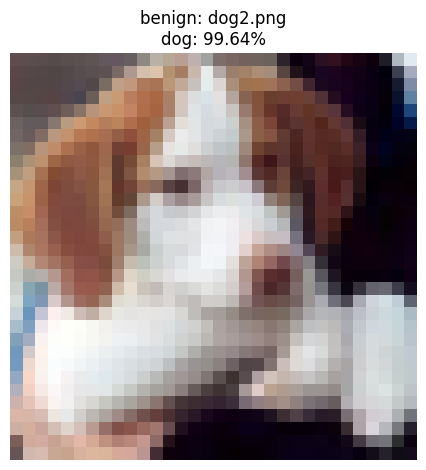

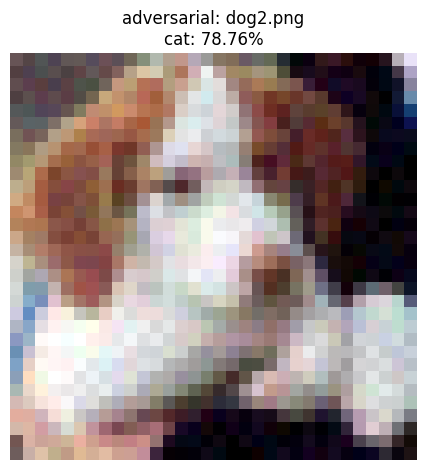

In [26]:
# original image
path = f'dog/dog2.png'
im = Image.open(f'./data/{path}')
logit = model(transform(im).unsqueeze(0))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'benign: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

# adversarial image
adv_im = Image.open(f'./fgsm/{path}')
logit = model(transform(adv_im).unsqueeze(0))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(adv_im))
plt.tight_layout()
plt.show()